In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy as sc

## Part 1: Baseline Calculation ###

In [2]:
#################################################################################
################## Insert Leap year days or delete it ###########################
#################################################################################

def insdel_leapdays(arr,start_year=1982,ny=41,opt='insert'):
    '''This Function insert/remove 29th february to each year (except leap years)
    Use for loop to include or delete 29th Feb map
    Input: 
    arr        :  SST array (time,lat,lon)
    start_year :  Start year
    ny         :  Total number of years in the dataset 
    opt        :  'insert'or'delete'          
    Output:
    arr        : Transformed array with included/excluded 29th February
    '''
    arr = arr*1
    idx = 31+27       ## ist 28th Feb ; assumes data start from 1st January

    for i in range(ny):
        # print(ds['sst'][idx].time.values)
        if (start_year+i)%4!=0: 
            if opt=='insert':
                arr = np.insert(arr, [idx], arr[idx+1,:,:] , axis=0)
            elif opt=='delete':
                arr = np.delete(arr, [idx], axis=0)
        # else:
            # print(start_year+i)

        if (start_year+i+1)%4==0:
            inc = 366
        else:
            inc = 365
        idx = idx+inc
    return arr

#################################################################################
################## Rolling 11 days climatology ##################################
#################################################################################

def calc_baseline(arr,window1=11,opt='clim',sti=0,eni=22):
    '''This Function calculates 11 days moving window climatology
    Do not Use for loop but use numpy array operation

    Input:   
    arr     :SST array with included 29th February
    Window1 : Window For climatology
    opt     :     'clim'/'pctl'
    sti     : start year index. Example:0
    eni     : end   year index. Example: 20


    '''
    arr    = np.concatenate([arr[-int(window1//2):,:,:,:],arr,arr[:int(window1//2),:,:,:]],axis=0)
    a_temp = np.lib.stride_tricks.sliding_window_view(arr,window1,axis=0)
    a_temp = a_temp[:,:,:,sti:eni,:]
    a_temp = np.reshape(a_temp,(a_temp.shape[0],a_temp.shape[1],a_temp.shape[2],a_temp.shape[3]*a_temp.shape[4]))
    
    if opt=='clim':
        clim = np.tile(np.mean(a_temp,axis=-1),(arr.shape[-1],1,1))
        return clim
    elif opt=='pctl':
        pctl = np.tile(np.percentile(a_temp,q=90,axis=-1),(arr.shape[-1],1,1))
        return pctl
    
#################################################################################
################## Rolling 31 days Smoothing ####################################
#################################################################################    

def rolling_mean(arr,window2=11):
    arr = np.concatenate([arr[-int(window2//2):,:,:],arr,arr[:int(window2//2),:,:]],axis=0)
    rm = np.lib.stride_tricks.sliding_window_view(arr,window2,axis=0).mean(axis=-1)
    return rm

In [3]:
ds          =   xr.open_dataset('/Users/panini/Downloads/oisst_x214216_y4042.nc')
years       =   np.unique(ds.time.dt.year.values)
sst         =   ds['sst'].values*1

#############  Insert 29th Feb in non leap years #######
sstlp   = insdel_leapdays(sst,start_year=years[0],ny=len(years),opt='insert')

############ converting sstlp to 366 X lat X lon X no.of years shape ######## 
array2  = np.reshape(sstlp,(366,sst.shape[1],sst.shape[2],len(years)),order='F')
print(array2.shape)

window1 = 11
window2 = 31

###### Calculate Baseline with specified No. of years data and specified window = 11 days ####
clim    = calc_baseline(array2,window1,opt='clim',sti=0,eni=30) ## start and end year index of climatology
pctl    = calc_baseline(array2,window1,opt='pctl',sti=0,eni=30) ## start and end year index of climatology

## Smoothing Baseline with specified days winddow window2 =31 days### 
clim_smooth    = rolling_mean(clim,window2)   
pctl_smooth    = rolling_mean(pctl,window2)

#############  Remove 29th Feb from non Leap years #######
sstlpd  = insdel_leapdays(sstlp,start_year=1982,ny=len(years),opt='delete')
climd   = insdel_leapdays(clim_smooth,start_year=1982,ny=len(years),opt='delete')
pctld   = insdel_leapdays(pctl_smooth,start_year=1982,ny=len(years),opt='delete')

(366, 8, 8, 41)


Text(0, 0.5, 'SST')

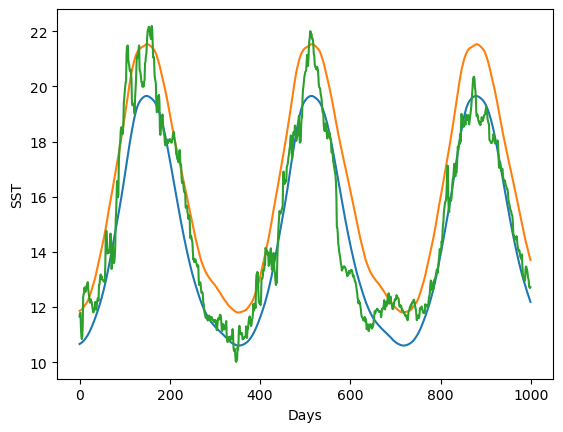

In [4]:
plt.plot(climd[-1000:,7,0])
plt.plot(pctld[-1000:,7,0])
plt.plot(sstlpd[-1000:,7,0])
plt.xlabel('Days')
plt.ylabel('SST')

## Part2: Event Detection 

In [5]:
###### 1d function detect  mhws ######
def detect_mhws(bool_arr,min_len=5,max_gap=0):

    """
    Unlike Hobday et al. (2016) this function doesnot use scipy.ndimage to identify event segments
    input 
    sst         :   Temperature 
    thresh      :   90th percentile
    min_len     :   5
    max_gap     :   2
    
    Return 
    ind1      :     where Temperature > Threshold
    ind2      :     where Temperature < Threshold
    """
    bool_arr = bool_arr*1
    ind1 = []
    ind2 = []
    z    = []
   
    t2 =  bool_arr[1:]
    t3 =  bool_arr[0:-1]
    z  =  t2-t3
   
    ind1 = np.where(z == 1)[0] +1
    ind2 = np.where(z == -1)[0]+1 

    if (ind1[0] > ind2[0]):
        ind2 = ind2[1:]
    if (ind1[-1]>ind2[-1]):
        ind1 = ind1[:-1]
    

    ### filter out < min_len (5 days) events ####
    ind_1 = np.where((ind2-ind1)< min_len)[0]
    ind1 = np.delete(ind1,ind_1)
    ind2 = np.delete(ind2,ind_1)

    ### Join maxgap (2 days) events ####
    k = ind1[1:] - ind2[:-1]
    w = np.where(k<=max_gap)[0]

    while len(w)>0:
        for j in w:
                ind2[j] = ind2[j+1]
        ind1 = np.delete(ind1,j+1)
        ind2 = np.delete(ind2,j+1)
        k = ind1[1:] - ind2[:-1]
        w = np.where(k<=max_gap)[0]
    ### Numbering the events from 1,2,3.....N
    ev = 1 ; arr = np.zeros(len(bool_arr))
    for ii in range(len(ind1)):
        arr[ind1[ii]:ind2[ii]] = ev
        ev+=1
    return arr

Text(0.5, 0, 'days')

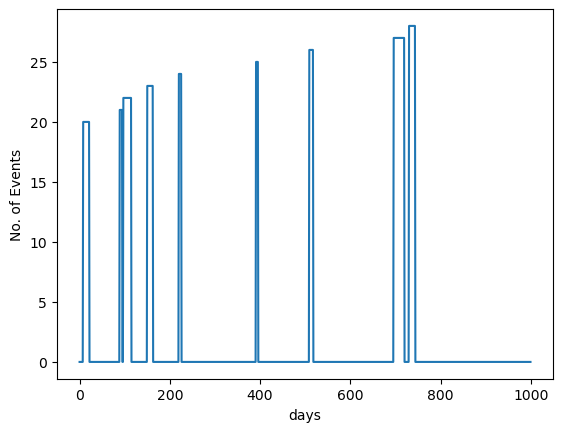

In [6]:
bool_arr = ((sstlpd-pctld)>0)*1
ie = np.apply_along_axis(detect_mhws,arr=bool_arr, axis=0)
plt.plot(ie[-1000:,7,0])
plt.ylabel('No. of Events')
plt.xlabel('days')